# DATA PREPARATION

## General

In [197]:
# Loading libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Creating file specification dataframes

data_labels = ['database','year','file','datnum','datname','datlen','digits','type','label']
core_labels_df = pd.read_fwf('D:\MLE Capstone Project\Data\FileSpecifications_NRD_2018_Core.txt',
                            colspecs=[(0,3),(4,8),(9,30),(36,39),(40,68),(69,71),(71,73),(73,77),(79,174)],
                            header=None, names=data_labels)
dx_labels_df = pd.read_fwf('D:\MLE Capstone Project\Data\FileSpecifications_NRD_2018_DX_PR_GRPS.txt',
                            colspecs=[(0,3),(4,8),(9,30),(36,39),(40,68),(69,71),(71,73),(73,77),(79,174)],
                            header=None, names=data_labels)
hosp_labels_df = pd.read_fwf('D:\MLE Capstone Project\Data\FileSpecifications_NRD_2018_Hospital.txt',
                            colspecs=[(0,3),(4,8),(9,30),(36,39),(40,68),(69,71),(71,73),(73,77),(79,174)],
                            header=None, names=data_labels)
sev_labels_df = pd.read_fwf('D:\MLE Capstone Project\Data\FileSpecifications_NRD_2018_Severity.txt',
                            colspecs=[(0,3),(4,8),(9,30),(36,39),(40,68),(69,71),(71,73),(73,77),(79,174)],
                            header=None, names=data_labels)

In [3]:
# Fixing data types in file specification dataframes

core_labels_df.loc[core_labels_df.type == 'Char', 'type'] = 'object'
core_labels_df.loc[core_labels_df.type == 'Num', 'type'] = 'int64'
core_labels_df.loc[np.isnan(core_labels_df.digits) == False, 'type'] = 'float64'

dx_labels_df.loc[dx_labels_df.type == 'Char', 'type'] = 'object'
dx_labels_df.loc[dx_labels_df.type == 'Num', 'type'] = 'int64'
dx_labels_df.loc[np.isnan(dx_labels_df.digits) == False, 'type'] = 'float64'

hosp_labels_df.loc[hosp_labels_df.type == 'Char', 'type'] = 'object'
hosp_labels_df.loc[hosp_labels_df.type == 'Num', 'type'] = 'int64'
hosp_labels_df.loc[np.isnan(hosp_labels_df.digits) == False, 'type'] = 'float64'

sev_labels_df.loc[sev_labels_df.type == 'Char', 'type'] = 'object'
sev_labels_df.loc[sev_labels_df.type == 'Num', 'type'] = 'int64'
sev_labels_df.loc[np.isnan(sev_labels_df.digits) == False, 'type'] = 'float64'

In [4]:
# Creating data type dictionaries

core_types = {core_labels_df['datname'].values.tolist()[i]:
              core_labels_df['type'].values.tolist()[i] for i in range(len(core_labels_df))}
dx_types = {dx_labels_df['datname'].values.tolist()[i]:
              dx_labels_df['type'].values.tolist()[i] for i in range(len(dx_labels_df))}
hosp_types = {hosp_labels_df['datname'].values.tolist()[i]:
              hosp_labels_df['type'].values.tolist()[i] for i in range(len(hosp_labels_df))}
sev_types = {sev_labels_df['datname'].values.tolist()[i]:
              sev_labels_df['type'].values.tolist()[i] for i in range(len(sev_labels_df))}

## Core Data

In [110]:
# Inspecting data labels in core data
# Drop 1,6-9,56-57,119

in_count = 0
for label in core_labels_df['label']:
    print(f'index {in_count}: '+ label)
    in_count += 1

index 0: Age in years at admission
index 1: Admission day is a weekend
index 2: Died during hospitalization
index 3: Weight to discharges in universe
index 4: Disposition of patient (uniform)
index 5: Discharge month
index 6: Discharge quarter
index 7: DRG in effect on discharge date
index 8: DRG grouper version used on discharge date
index 9: DRG in use on discharge date, calculated without POA
index 10: ICD-10-CM Diagnosis 1
index 11: ICD-10-CM Diagnosis 2
index 12: ICD-10-CM Diagnosis 3
index 13: ICD-10-CM Diagnosis 4
index 14: ICD-10-CM Diagnosis 5
index 15: ICD-10-CM Diagnosis 6
index 16: ICD-10-CM Diagnosis 7
index 17: ICD-10-CM Diagnosis 8
index 18: ICD-10-CM Diagnosis 9
index 19: ICD-10-CM Diagnosis 10
index 20: ICD-10-CM Diagnosis 11
index 21: ICD-10-CM Diagnosis 12
index 22: ICD-10-CM Diagnosis 13
index 23: ICD-10-CM Diagnosis 14
index 24: ICD-10-CM Diagnosis 15
index 25: ICD-10-CM Diagnosis 16
index 26: ICD-10-CM Diagnosis 17
index 27: ICD-10-CM Diagnosis 18
index 28: ICD-10

In [111]:
# Loading core dateframe in batches via TextFileReader context

core_df = pd.read_csv(r'D:\MLE Capstone Project\Data\NRD_2018_Core.CSV',
                      header=None, names=core_labels_df['datname'].values.tolist(), dtype=core_types,
                      iterator=True, chunksize=5000)

In [112]:
# Inspecting elements of first batch of core dataframe

for df in core_df:
    counter = 0
    print(df.info())
    counter += 1
    if counter == 1:
        break

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 121 entries, AGE to ZIPINC_QRTL
dtypes: float64(1), int64(53), object(67)
memory usage: 4.6+ MB
None


In [113]:
# Creating lists of variables to drop or recode from core data

core_variables = core_labels_df['datname'].values.tolist()
core_ICD10_dx = []
core_ICD10_dx.extend(core_variables[10:50])
core_ICD10_proc = []
core_ICD10_proc.extend(core_variables[65:90])
core_days_to_proc = []
core_days_to_proc.extend(core_variables[90:115])
core_to_drop = []
core_to_drop.extend(core_variables[1:2] + core_variables[6:10] + core_variables[56:58] + core_variables[119:120])

In [114]:
# Creating diagnosis, procedure, and days to procedure variables
# Dropping unnecessary variables from core data to reduce memory usage
# Dropping non-MBD observations from core data to reduce memory usage
# Concatenating chunks into single core dataframe

def find_MBD_diagnosis(data, variables):
    data['HAS_MBD'] = 0
    data['MBD_dx'] = ""
    for variable in variables:
        data['HAS_MBD'] = np.where(data[variable].str.contains("^F\d+") == True, 1, data['HAS_MBD'])
        data['MBD_dx'] = np.where((data[variable].str.contains("^F\d+") == True) & (data['MBD_dx'] == None),
                                   data[variable].astype(str), data['MBD_dx'])
        data['MBD_dx'] = np.where((data[variable].str.contains("^F\d+") == True) & (data['MBD_dx'] != None),
                                   data['MBD_dx'].astype(str) + ' ' + data[variable].astype(str), data['MBD_dx'])
    data.drop(columns = variables, inplace=True)

def find_procedure(data, variables):
    data['Procedure'] = ""
    for variable in variables:
        data['Procedure'] = np.where((data[variable].notna()) & (data['Procedure'] == None),
                                       data[variable].astype(str), data['Procedure'])
        data['Procedure'] = np.where((data[variable].notna()) & (data['Procedure'] != None),
                                       data['Procedure'].astype(str) + ' ' + data[variable].astype(str), data['Procedure'])
    data.drop(columns = variables, inplace=True)

def calculate_day_to_proc(data, variables):
    for variable in variables:
        data[variable] = np.where(data[variable] == -99, np.nan, data[variable])
    data['avg_days_to_proc'] = data[variables].mean(axis=1, skipna=True, numeric_only=True).round(2)
    data.drop(columns = variables, inplace=True)
        
core_data = pd.DataFrame()        
        
for df in core_df:
    df.drop(columns = core_to_drop, inplace=True) 
    find_MBD_diagnosis(df, core_ICD10_dx)
    df = df[df.HAS_MBD == 1]
    df.drop(columns = 'HAS_MBD', inplace=True)
    find_procedure(df, core_ICD10_proc)
    calculate_day_to_proc(df, core_days_to_proc)
    core_data = pd.concat([core_data, df], ignore_index=True, copy=False)

In [115]:
# Saving core data as a csv for quick reloading of data

core_data.to_csv(r'D:\MLE Capstone Project\Data\core_data.csv', index=False)

## Diagnosis Data

In [117]:
# Inspecting data labels in diagnosis data
# MBD (Mental, Behavioral, and neurodevelopmental disorders) body system (288 - 319)
# Identifiers (542 - 543)

in_count = 0
for label in dx_labels_df['label']:
    print(f'index {in_count}: '+ label)
    in_count += 1

index 0: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD001
index 1: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD002
index 2: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD003
index 3: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD004
index 4: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD005
index 5: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD006
index 6: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD007
index 7: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD008
index 8: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD009
index 9: Indication that at least one ICD-10-CM diagnosis on the record is included in CCSR BLD010
index 10: 

In [387]:
# Loading diagnosis dataframe in batches via TextFileReader context

dx_df = pd.read_csv(r'D:\MLE Capstone Project\Data\NRD_2018_DX_PR_GRPS.CSV',
                    header=None, names=dx_labels_df['datname'].values.tolist(), dtype=dx_types,
                    iterator=True, chunksize=5000)

In [388]:
# Inspecting elements of first batch of diagnosis and procedure dataframe

for df in dx_df:
    counter = 0
    print(df.head())
    print(df.info())
    counter += 1
    if counter == 1:
        break

   DXCCSR_BLD001  DXCCSR_BLD002  DXCCSR_BLD003  DXCCSR_BLD004  DXCCSR_BLD005  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              3              0   
4              0              0              0              0              0   

   DXCCSR_BLD006  DXCCSR_BLD007  DXCCSR_BLD008  DXCCSR_BLD009  DXCCSR_BLD010  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   ...  DXCCSR_SYM012  DXCCSR_SYM013  

In [389]:
# Creating lists of variables to drop or recode from diagnosis data

dx_variables = dx_labels_df['datname'].values.tolist()
dx_to_drop = []
dx_to_drop.extend(dx_variables[0:288] + dx_variables[320:540] + dx_variables[541:542])
dx_to_recode = []
dx_to_recode.extend(dx_variables[288:320])

In [390]:
# Creating primary and secondary MBD diagnosis variables
# Dropping unnecessary variables from diagnosis data to reduce memory usage
# Dropping non-MBD observations from diagnosis data to reduce memory usage
# Concatenating chunks into single diagnosis dataframe

def create_diagnosis(data, variables):
    data['Primary_dx'] = ""
    data['Secondary_dx'] = ""
    for variable in variables:
        data['Primary_dx'] = np.where((data[variable] == 1) | (data[variable] == 2),
                                       data['Primary_dx'].astype(str) + ' ' + variable.replace('DXCCSR_',''),
                                       data['Primary_dx'])
        data['Secondary_dx'] = np.where((data[variable] == 3) | (data[variable] == 2),
                                         data['Secondary_dx'].astype(str) + ' ' + variable.replace('DXCCSR_',''),
                                         data['Secondary_dx'])

dx_data = pd.DataFrame()        
        
for df in dx_df:
    df.drop(columns = dx_to_drop, inplace=True)
    df['HAS_MBD'] = np.where(df.iloc[:, 0:33].max(axis=1, numeric_only=True) != 0, True, False)
    df = df[df.HAS_MBD == True]
    create_diagnosis(df, dx_to_recode)
    df.drop(columns = dx_to_recode, inplace=True)
    df.drop(columns = 'HAS_MBD', inplace=True)
    dx_data = pd.concat([dx_data, df], ignore_index=True, copy=False)

In [391]:
# Saving diagnosis data as a csv for quick reloading of data

dx_data.to_csv(r'D:\MLE Capstone Project\Data\DX_data.csv', index=False)

## Hospital Data

In [57]:
# Inspecting data labels in hospital data

in_count = 0
for label in hosp_labels_df['label']:
    print(f'index {in_count}: '+ label)
    in_count += 1

index 0: Bed size of hospital
index 1: Control/ownership of hospital
index 2: NRD hospital identifier
index 3: Hospital urban-rural designation
index 4: Teaching status of urban hospitals
index 5: NRD stratum used for weighting
index 6: Number of universe discharges in NRD_STRATUM
index 7: Number of universe hospitals in NRD_STRATUM
index 8: Number of sample discharges in NRD_STRATUM
index 9: Number of universe hospitals in NRD_STRATUM
index 10: Total hospital discharges
index 11: Calendar year


In [59]:
# Loading hospital dataframe and inspecting elements

hospital_df = pd.read_csv(r'D:\MLE Capstone Project\Data\NRD_2018_Hospital.CSV',
                      header=None, names=hosp_labels_df['datname'].values.tolist(), dtype=hosp_types)
print(hospital_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   HOSP_BEDSIZE   2430 non-null   int64
 1   H_CONTRL       2430 non-null   int64
 2   HOSP_NRD       2430 non-null   int64
 3   HOSP_URCAT4    2430 non-null   int64
 4   HOSP_UR_TEACH  2430 non-null   int64
 5   NRD_STRATUM    2430 non-null   int64
 6   N_DISC_U       2430 non-null   int64
 7   N_HOSP_U       2430 non-null   int64
 8   S_DISC_U       2430 non-null   int64
 9   S_HOSP_U       2430 non-null   int64
 10  TOTAL_DISC     2430 non-null   int64
 11  YEAR           2430 non-null   int64
dtypes: int64(12)
memory usage: 227.9 KB


In [60]:
# Dropping unnecessary variables from hospital data to reduce memory usage later

hospital_df.drop(columns = ['S_DISC_U','S_HOSP_U','YEAR'], inplace=True)

## Severity Data

In [61]:
# Inspecting data labels in severity data
# APRDRG is diagnosis-related group and indicates hospital resource use
# Risk_Mortality is ordinal risk of death
# Severity is ordinal loss of function

for label in sev_labels_df['label']:
    print(label)

All Patient Refined DRG
All Patient Refined DRG: Risk of Mortality Subclass
All Patient Refined DRG: Severity of Illness Subclass
NRD hospital identifier
NRD record identifier


In [62]:
# Loading severity dataframe and inspecting elements

severity_df = pd.read_csv(r'D:\MLE Capstone Project\Data\NRD_2018_Severity.CSV',
                      header=None, names=sev_labels_df['datname'].values.tolist(), dtype=sev_types)
print(severity_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17686511 entries, 0 to 17686510
Data columns (total 5 columns):
 #   Column                 Dtype
---  ------                 -----
 0   APRDRG                 int64
 1   APRDRG_Risk_Mortality  int64
 2   APRDRG_Severity        int64
 3   HOSP_NRD               int64
 4   KEY_NRD                int64
dtypes: int64(5)
memory usage: 674.7 MB
None


# Readmission Data Processing

In [172]:
# Loading prepared core data and double-checking contents

readmit_df = pd.read_csv(r'D:\MLE Capstone Project\Data\core_data.csv').sort_values(by=['NRD_VisitLink','NRD_DaysToEvent'])
print(readmit_df.info())
print(readmit_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7491640 entries, 2817380 to 1469871
Data columns (total 26 columns):
 #   Column            Dtype  
---  ------            -----  
 0   AGE               int64  
 1   DIED              int64  
 2   DISCWT            float64
 3   DISPUNIFORM       int64  
 4   DMONTH            int64  
 5   ELECTIVE          int64  
 6   FEMALE            int64  
 7   HCUP_ED           int64  
 8   HOSP_NRD          int64  
 9   KEY_NRD           int64  
 10  LOS               int64  
 11  I10_NDX           int64  
 12  I10_NPR           int64  
 13  NRD_DaysToEvent   int64  
 14  NRD_STRATUM       int64  
 15  NRD_VisitLink     object 
 16  PAY1              int64  
 17  PL_NCHS           int64  
 18  REHABTRANSFER     int64  
 19  RESIDENT          int64  
 20  SAMEDAYEVENT      int64  
 21  TOTCHG            int64  
 22  ZIPINC_QRTL       int64  
 23  MBD_dx            object 
 24  Procedure         object 
 25  avg_days_to_proc  float64
dtypes: float

In [175]:
# Creating dataframes holding records with or without readmission
# NRD Visit Link: Verified patient linkage number for linking hospital visits for the same patient across hospitals
# NRD_DaysToEvent: Difference between admission date and a unique, assigned start date associated with the Visit Link


Never_Readmit = readmit_df[readmit_df.duplicated(subset='NRD_VisitLink',keep=False) == False]
Was_Readmit = readmit_df[readmit_df.duplicated(subset='NRD_VisitLink',keep=False) == True]
First_Admit = Was_Readmit.drop_duplicates(subset='NRD_VisitLink')

print("There are {} records without duplicates".format(len(Never_Readmit)))
print("There are {} non-unique records with at least one duplicate".format(len(Was_Readmit)))
print("There are {} unique records with at least one duplicate".format(len(First_Admit)))

There are 4190121 records without duplicates
There are 3301519 non-unique records with at least one duplicate
There are 1218165 unique records with at least one duplicate


In [178]:
# Creating readmission count variable

Was_Readmit = Was_Readmit.reset_index(drop=True)
# Tiny_Dataset = Was_Readmit[0:1000].reset_index(drop=True)

def calculate_visit_count(data):
    data['Visit_Count'] = 0
    for i in range(0,len(data)):
        j = 1
        if data.loc[i, 'Visit_Count'] == 0:
            data.loc[i, 'Visit_Count'] = j
            while data.loc[i, 'NRD_VisitLink'] == data.loc[i+j, 'NRD_VisitLink']:
                data.loc[i+j, 'Visit_Count'] = j + 1
                j += 1
                if i+j == len(data):
                    break
                else:
                    continue
        else:
            continue

calculate_visit_count(Was_Readmit)
print(Was_Readmit.info())
print(Was_Readmit[['NRD_VisitLink','NRD_DaysToEvent','Visit_Count']].head(10))
print(Was_Readmit['Visit_Count'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3301519 entries, 0 to 3301518
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   AGE               int64  
 1   DIED              int64  
 2   DISCWT            float64
 3   DISPUNIFORM       int64  
 4   DMONTH            int64  
 5   ELECTIVE          int64  
 6   FEMALE            int64  
 7   HCUP_ED           int64  
 8   HOSP_NRD          int64  
 9   KEY_NRD           int64  
 10  LOS               int64  
 11  I10_NDX           int64  
 12  I10_NPR           int64  
 13  NRD_DaysToEvent   int64  
 14  NRD_STRATUM       int64  
 15  NRD_VisitLink     object 
 16  PAY1              int64  
 17  PL_NCHS           int64  
 18  REHABTRANSFER     int64  
 19  RESIDENT          int64  
 20  SAMEDAYEVENT      int64  
 21  TOTCHG            int64  
 22  ZIPINC_QRTL       int64  
 23  MBD_dx            object 
 24  Procedure         object 
 25  avg_days_to_proc  float64
 26  Visit_Count   

In [461]:
print(Was_Readmit[Was_Readmit.DMONTH <= 12]['Visit_Count'].value_counts())

1     1218165
2     1218165
3      435782
4      192042
5       96393
6       53202
7       31388
8       19454
9       12627
10       8330
11       5610
12       3838
13       2547
14       1693
15       1069
16        641
17        352
18        165
19         56
Name: Visit_Count, dtype: int64


There are 5,408,286 unique individuals in this data. 4,190,121 individuals (77.48%) were not readmitted and 1,218,165 individuals (22.52%) were readmitted at least once. There are 2,083,354 readmission records in total. Of these readmission records, 100% were readmitted 2x, 36% were readmitted 3x, 16% were readmitted 4x, 8% were readmitted 5x, 4% were readmitted 6x, 3% were readmitted 7x, 2% were readmitted 8x, 1% were readmitted 9x, and <1% were readmitted >= 10x.

In [187]:
# Saving readmission data as a csv for quick reloading of data

Never_Readmit['Visit_Count'] = 1
Never_Readmit = Never_Readmit.reset_index(drop=True)

Readmission_df = pd.concat([Never_Readmit,Was_Readmit], ignore_index=True)

Readmission_df.to_csv(r'D:\MLE Capstone Project\Data\readmission_data.csv', index=False)

# Exploratory Data Analysis

## EDA of Hospital Data

[[<AxesSubplot:title={'center':'HOSP_BEDSIZE'}>
  <AxesSubplot:title={'center':'H_CONTRL'}>]
 [<AxesSubplot:title={'center':'HOSP_URCAT4'}>
  <AxesSubplot:title={'center':'HOSP_UR_TEACH'}>]]


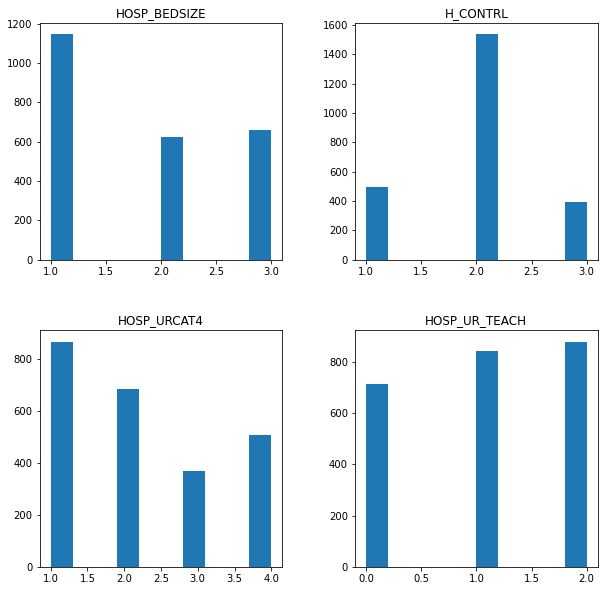

In [205]:
# Plotting the hospital data (categorial variables only)

Hospital_IVs = ['HOSP_BEDSIZE','H_CONTRL','HOSP_URCAT4','HOSP_UR_TEACH']
print(hospital_df.hist(column=Hospital_IVs,figsize=(10,10),grid=False))

In [206]:
for variable in Hospital_IVs:
    print(hospital_df[variable].value_counts(normalize=True))

1    0.471605
3    0.271605
2    0.256790
Name: HOSP_BEDSIZE, dtype: float64
2    0.632099
1    0.204938
3    0.162963
Name: H_CONTRL, dtype: float64
1    0.356790
2    0.281893
4    0.209465
3    0.151852
Name: HOSP_URCAT4, dtype: float64
2    0.361317
1    0.345679
0    0.293004
Name: HOSP_UR_TEACH, dtype: float64


In [204]:
# Checking for missing values

print(hospital_df.isna().value_counts())

HOSP_BEDSIZE  H_CONTRL  HOSP_NRD  HOSP_URCAT4  HOSP_UR_TEACH  NRD_STRATUM  N_DISC_U  N_HOSP_U  TOTAL_DISC
False         False     False     False        False          False        False     False     False         2430
dtype: int64


We can see that there is no missing data in the hospital dataframe. Approximately 47% of the hospitals are small, 27% are medium, and 26% are large. Approximately 63% of hospitals are public, 20% are non-profit, and 16% are private. Approximately 36% of hospitals serve large metropolitan areas, 28% serve small metropolitan areas, 21% serve micropolitan areas, and 15% serve rural areas. Approximately 29% of metropolitan hospitals are non-teaching hospitals, 35% of metropolitan hospitals are teaching hospitals, and 36% of hospitals are non-metropolitan (for which teaching status does not apply).

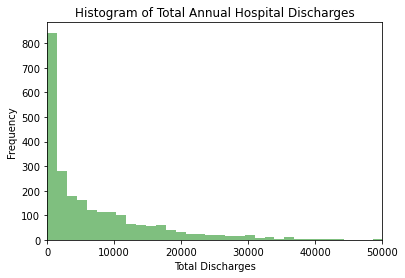

In [216]:
# Plotting the hospital data (continuous variables only)

x = hospital_df.TOTAL_DISC
n, bins, patches = plt.hist(x, 80, facecolor='g', alpha=0.50)
plt.xlabel('Total Discharges')
plt.ylabel('Frequency')
plt.title('Histogram of Total Annual Hospital Discharges')
plt.xlim(0, 50000)
plt.show()

In [228]:
hospital_df.TOTAL_DISC[hospital_df.TOTAL_DISC > 55723].value_counts()

66129     1
56614     1
55920     1
80969     1
71770     1
117994    1
115372    1
56040     1
83979     1
Name: TOTAL_DISC, dtype: int64

In [211]:
hospital_df.TOTAL_DISC.describe()

count      2430.000000
mean       7278.399588
std        9689.264632
min           2.000000
25%         727.000000
50%        3660.500000
75%       10430.750000
max      117994.000000
Name: TOTAL_DISC, dtype: float64

The typical hospital has fewer than 7000 discharges (note that this variable has a Poisson distribution). There are nine hospitals with total discharges more than 5 SD above the mean. These are potential outliers, whose effects could be attenuated by transforming this variable and/or winsorizing.

## EDA of Diagnosis and Severity Data

In [392]:
# Merging the severity data with the diagnosis data

dx_severity_df = pd.merge(dx_data, severity_df, how='left', on=['KEY_NRD','HOSP_NRD'])
print(dx_severity_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6868452 entries, 0 to 6868451
Data columns (total 8 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   DXCCSR_DEFAULT_DX1     object
 1   HOSP_NRD               int64 
 2   KEY_NRD                int64 
 3   Primary_dx             object
 4   Secondary_dx           object
 5   APRDRG                 int64 
 6   APRDRG_Risk_Mortality  int64 
 7   APRDRG_Severity        int64 
dtypes: int64(5), object(3)
memory usage: 471.6+ MB
None


[[<AxesSubplot:title={'center':'APRDRG_Risk_Mortality'}>
  <AxesSubplot:title={'center':'APRDRG_Severity'}>]]


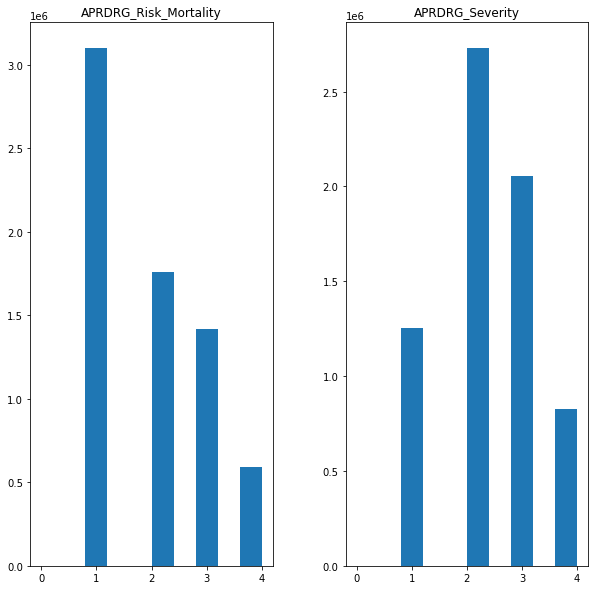

In [393]:
# Plotting the severity data

print(dx_severity_df.hist(column=['APRDRG_Risk_Mortality','APRDRG_Severity'],figsize=(10,10),grid=False))

In [235]:
# Counting the DRG's

print(dx_severity_df['APRDRG'].nunique())
print(dx_severity_df['APRDRG'].value_counts())

324
720    428389
751    238301
194    212544
750    187826
140    185805
        ...  
607         2
612         1
613         1
623         1
589         1
Name: APRDRG, Length: 324, dtype: int64


This sample (which is composed of patients with at least one MBD diagnosis, be it primary or secondary) is generally categorized as minor to moderate risk of mortality, but with moderate to major loss of function. This potentially fits the profile of MBD diagnosis, which (as a primary diagnosis depending on the specific condition) are likely to be associated with a significant loss of function without necessarily high risk of mortality. Individuals are grouped into 324 different diagnosis related groups (DRG's) which use factors like illness, severity, medications, and procedures to estimate the likely cost of the patient's treatment.

In [394]:
# Investigating the frequency of MBD diagnoses as the primary or secondary diagnosis

Total_Cases = dx_severity_df.DXCCSR_DEFAULT_DX1.count()
MBD_Default_Cases = dx_severity_df.DXCCSR_DEFAULT_DX1[dx_severity_df.DXCCSR_DEFAULT_DX1.str.contains('MBD') == True].count()
MBD_Primary_Cases = dx_severity_df.Primary_dx[dx_severity_df.Primary_dx.str.contains('MBD') == True].count()

print("There are {} cases with at least one MBD diagnosis, which is {}% of the original case count."
      .format(Total_Cases, "%.2f" % (Total_Cases/17686511*100)))
print("Only {} of these relevant cases, or {}%, have an MBD diagnosis as the default primary diagnosis."
      .format(MBD_Default_Cases, "%.2f" % (MBD_Default_Cases/Total_Cases*100)))
print("There are {} cases, or {}%, with an MBD diagnosis as or related to the default primary diagnosis."
      .format(MBD_Primary_Cases, "%.2f" % (MBD_Primary_Cases/Total_Cases*100)))

There are 6868452 cases with at least one MBD diagnosis, which is 38.83% of the original case count.
Only 1044032 of these relevant cases, or 15.20%, have an MBD diagnosis as the default primary diagnosis.
There are 1191188 cases, or 17.34%, with an MBD diagnosis as or related to the default primary diagnosis.


It's clear that I would lose a large proportion of the possible observations (n = 5,677,264) if I restricted my analysis only to patients with an MBD code as or related to the primary diagnosis. However, this is worth considering because there is a substantial difference between an MBD as a comorbidity (which is what these represent) and MBD as the primary reason for hospitalization. The use case of predicting readmission differs if comorbid MBD is permitted.

In [396]:
# Replacing missing values with NaN

dx_severity_df['Primary_dx'] = np.where(dx_severity_df['Primary_dx'] == "", np.nan, dx_severity_df['Primary_dx'])
dx_severity_df['Secondary_dx'] = np.where(dx_severity_df['Secondary_dx'] == "", np.nan, dx_severity_df['Secondary_dx'])

In [397]:
# Replacing invalid values with NaN

dx_severity_df['APRDRG_Risk_Mortality'] = np.where(dx_severity_df['APRDRG_Risk_Mortality'] == 0,
                                                   np.nan, dx_severity_df['APRDRG_Risk_Mortality'])
dx_severity_df['APRDRG_Severity'] = np.where(dx_severity_df['APRDRG_Severity'] == 0,
                                             np.nan, dx_severity_df['APRDRG_Severity'])

In [398]:
# Checking missing values

for variable in dx_severity_df:
    print(dx_severity_df[variable].isna().value_counts())

False    6868452
Name: DXCCSR_DEFAULT_DX1, dtype: int64
False    6868452
Name: HOSP_NRD, dtype: int64
False    6868452
Name: KEY_NRD, dtype: int64
True     5677264
False    1191188
Name: Primary_dx, dtype: int64
False    6746917
True      121535
Name: Secondary_dx, dtype: int64
False    6868452
Name: APRDRG, dtype: int64
False    6867447
True        1005
Name: APRDRG_Risk_Mortality, dtype: int64
False    6867447
True        1005
Name: APRDRG_Severity, dtype: int64


The variables with the most missing data are Primary_dx and Secondary_dx. Primary_dx is missing for a majority of the observations (n = 5,677,264) because most patients do not have an MBD diagnosis as their default primary diagnosis; instead it is related to some other body system. Secondary_dx is missing for a relatively small number of the observations (n = 121,535) because some patients do not have any secondary diagnoses (it should be noted that this is not the number of participants with no secondary diagnosis, the HCUP data lists some primary diagnoses as the secondary diagnosis). A very small number of observations do not have a specified class for severity or risk of mortality, so this was treated as missing data.

In [399]:
# Checking the pattern of MBD codes

print("There are {} unique primary MBD diagnosis codes.".format(dx_severity_df['Primary_dx'].nunique()))
print("There are {} unique secondary MBD diagnosis code patterns.".format(dx_severity_df['Secondary_dx'].nunique()))

There are 57 unique primary MBD diagnosis codes.
There are 49591 unique secondary MBD diagnosis code patterns.


In [279]:
# Checking the frequency of secondary MBD codes by count

dx_severity_df['MBD_Count'] = dx_severity_df.Secondary_dx.str.count("MBD")
print(dx_severity_df.MBD_Count.value_counts())
print(dx_severity_df.MBD_Count.describe())

1.0     3574990
2.0     1819347
3.0      770903
4.0      328251
5.0      146510
6.0       64161
7.0       26927
8.0       10432
9.0        3656
10.0       1230
11.0        378
12.0         96
13.0         27
14.0          8
15.0          1
Name: MBD_Count, dtype: int64
count    6.746917e+06
mean     1.820068e+00
std      1.163723e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.500000e+01
Name: MBD_Count, dtype: float64


There are a managable number of unique primary MBD codes (k = 37), which makes sense because there are only 34 possible codes. However, there are a staggering number of unique secondary MBD codes (k = 49,592) because there are 34 possible codes that can be combined a number of times (M = 1.82, SD = 1.16) in any number of combinations. The vast majority of observations have 1 - 3 secondary codes, but a relatively small proportion of observations have an increasing number of secondary codes (max = 15). It might be preferable to reduce the dimensionality of this secondary diagnosis variable, for example by first running the text through a TF_IDF vectorizer before running K-means clustering or some other relevant clustering algorithm.

## EDA of Core Data

[[<AxesSubplot:title={'center':'AGE'}>
  <AxesSubplot:title={'center':'DIED'}>
  <AxesSubplot:title={'center':'DISCWT'}>
  <AxesSubplot:title={'center':'DISPUNIFORM'}>]
 [<AxesSubplot:title={'center':'DMONTH'}>
  <AxesSubplot:title={'center':'ELECTIVE'}>
  <AxesSubplot:title={'center':'FEMALE'}>
  <AxesSubplot:title={'center':'HCUP_ED'}>]
 [<AxesSubplot:title={'center':'LOS'}>
  <AxesSubplot:title={'center':'I10_NDX'}>
  <AxesSubplot:title={'center':'I10_NPR'}>
  <AxesSubplot:title={'center':'PAY1'}>]
 [<AxesSubplot:title={'center':'PL_NCHS'}>
  <AxesSubplot:title={'center':'REHABTRANSFER'}>
  <AxesSubplot:title={'center':'RESIDENT'}>
  <AxesSubplot:title={'center':'TOTCHG'}>]
 [<AxesSubplot:title={'center':'ZIPINC_QRTL'}>
  <AxesSubplot:title={'center':'avg_days_to_proc'}> <AxesSubplot:>
  <AxesSubplot:>]]


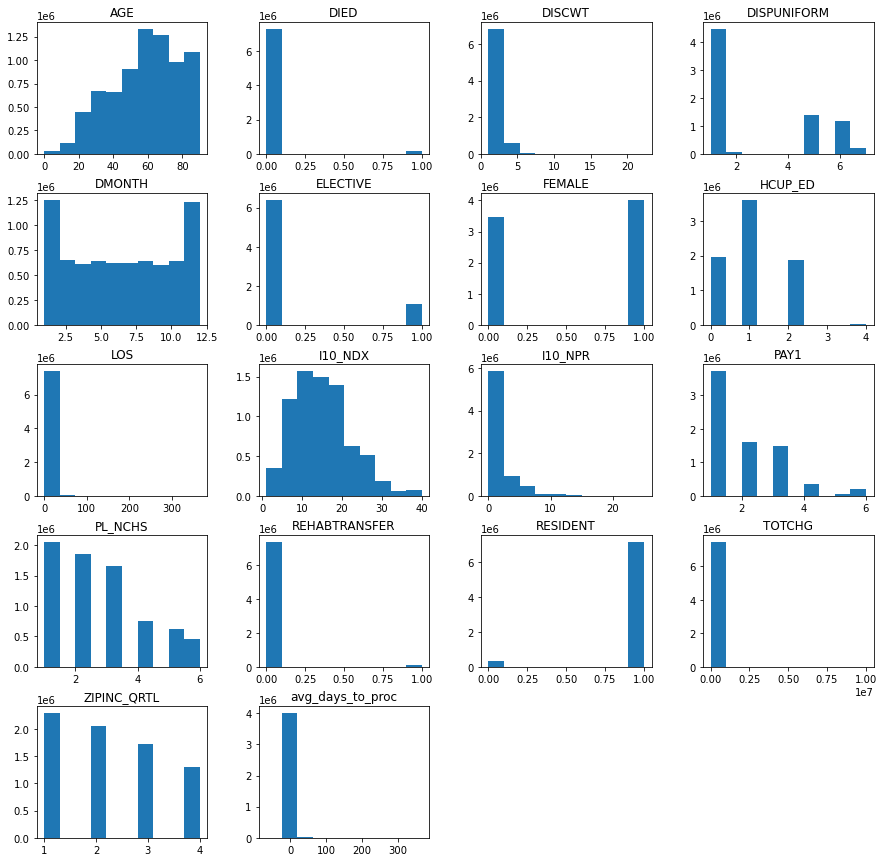

In [321]:
# Plotting the core data

core_variables = ['AGE','DIED','DISCWT','DISPUNIFORM','DMONTH','ELECTIVE','FEMALE','HCUP_ED','LOS','I10_NDX',\
                  'I10_NPR','PAY1','PL_NCHS','REHABTRANSFER','RESIDENT','SAMEDAYEVENT','TOTCHG','ZIPINC_QRTL',\
                  'MBD_dx','Procedure','avg_days_to_proc']

print(core_data.hist(column=core_variables,figsize=(15,15),grid=False))  

In [293]:
# Inspecting frequency counts and descriptive statistics for core data

for variable in core_variables:
    print(core_data[variable].value_counts())
    print("\n")
    print(core_data[variable].describe())
    print("\n")
    # print(\n core_data[variable].isna().value_counts())

90    331517
61    153361
60    153246
59    152220
58    151643
       ...  
3       2922
1       2797
4       2742
5       2723
0       1236
Name: AGE, Length: 91, dtype: int64


count    7.491640e+06
mean     5.793272e+01
std      1.991537e+01
min      0.000000e+00
25%      4.400000e+01
50%      6.000000e+01
75%      7.300000e+01
max      9.000000e+01
Name: AGE, dtype: float64


 0    7317882
 1     169014
-9       4225
-8        519
Name: DIED, dtype: int64


count    7.491640e+06
mean     1.693047e-02
std      2.690509e-01
min     -9.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: DIED, dtype: float64


1.343653     103943
1.953018     101934
1.979286      99632
1.569509      90638
1.402083      85414
              ...  
3.425708          1
10.925781         1
5.288525          1
22.238411         1
2.454962          1
Name: DISCWT, Length: 876, dtype: int64


count    7.491640e+06
mean     1.884090e+00
std      7.434590e-01

count    4.045567e+06
mean     1.756404e+00
std      4.153748e+00
min     -6.600000e+01
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.650000e+02
Name: avg_days_to_proc, dtype: float64




In [ ]:
# DIED -9, -8 to NaN
# DISPUNIFORM 99, 20, -9, -8 to NaN
# ELECTIVE -9, -8 to NaN
# PAY1 -8, -9 to NaN
# PL_NCHS -99 to NaN
# TOTCHG -999999999, -888888888, -666666666 to NaN
# ZIPINC_QRTL -8, -9 to NaN
# LOS -9999, -8888, -6666 to NaN

In [319]:
# Replacing missing or invalid values with NaN

core_data['DIED'] = np.where(core_data['DIED'] <= -8, np.nan, core_data['DIED'])
core_data['DISPUNIFORM'] = np.where((core_data['DISPUNIFORM'] <= -8) | (core_data['DISPUNIFORM'] >= 20),
                                    np.nan, core_data['DISPUNIFORM'])
core_data['ELECTIVE'] = np.where(core_data['ELECTIVE'] <= -8, np.nan, core_data['ELECTIVE'])
core_data['PAY1'] = np.where(core_data['PAY1'] <= -8, np.nan, core_data['PAY1'])
core_data['PL_NCHS'] = np.where(core_data['PL_NCHS'] == -99, np.nan, core_data['PL_NCHS'])
core_data['ZIPINC_QRTL'] = np.where(core_data['ZIPINC_QRTL'] <= -8, np.nan, core_data['ZIPINC_QRTL'])
core_data['TOTCHG'] = np.where(core_data['TOTCHG'] <= -666666666, np.nan, core_data['TOTCHG'])
core_data['LOS'] = np.where(core_data['LOS'] <= -6666, np.nan, core_data['LOS'])

In [320]:
# Checking core data missing values

for variable in core_variables:
    print(core_data[variable].isna().value_counts())
    print("\n")

False    7491640
Name: AGE, dtype: int64


False    7486896
True        4744
Name: DIED, dtype: int64


False    7491640
Name: DISCWT, dtype: int64


False    7316219
True      175421
Name: DISPUNIFORM, dtype: int64


False    7491640
Name: DMONTH, dtype: int64


False    7483274
True        8366
Name: ELECTIVE, dtype: int64


False    7491640
Name: FEMALE, dtype: int64


False    7491640
Name: HCUP_ED, dtype: int64


False    7491041
True         599
Name: LOS, dtype: int64


False    7491640
Name: I10_NDX, dtype: int64


False    7491640
Name: I10_NPR, dtype: int64


False    7478546
True       13094
Name: PAY1, dtype: int64


False    7402192
True       89448
Name: PL_NCHS, dtype: int64


False    7491640
Name: REHABTRANSFER, dtype: int64


False    7491640
Name: RESIDENT, dtype: int64


False    7491640
Name: SAMEDAYEVENT, dtype: int64


False    7488695
True        2945
Name: TOTCHG, dtype: int64


False    7391731
True       99909
Name: ZIPINC_QRTL, dtype: int64


False    749164

There is a modest amount of missing data in a number of variables, with the exception of avg_days_to_proc for which many patients do not have data because no procedures were performed. There are some potential outliers in LOS (length of stay) and TOTCHG (total charge) because, in rare instances, patients might stay for many months and receive treatments costing many millions of dollars. It might make sense to remove these outliers because they have very severe conditions, but paradoxically are less likely to be readmitted (since they are not discharged to be readmitted).

There are 801,023 unique diagnosis code patterns and 1,289,332 unique procedure code patterns in the core data. As was suggested for the primary and secondary diagnosis patterns in the diagnosis and severity data EDA, it might be preferable to reduce the dimensionality of these variables by, for example, first running the text through a TF_IDF vectorizer before running K-means clustering or some other relevant clustering algorithm. There were approximately 50,000 unique patterns of MBD codes because these are composed of the courser 34-option code system. The diagnosis and procedure codes in the core data are finer grained and so there are a lot more unique patterns of codes.

## Preparation and EDA of Data for Modeling

In [403]:
# Preparing combined dataframe

# Remove observations for which MBD is not associated with the primary diagosis
dx_sev_short = dx_severity_df.dropna(subset=['Primary_dx'])
# Join hospital data to diagnosis and severity data
dx_sev_hosp_df = pd.merge(dx_sev_short, hospital_df, how='left', on='HOSP_NRD')
# Join core data to combined diagnosis, severity, and hospital data
combined_df = pd.merge(dx_sev_hosp_df, core_data, how='left', on=['KEY_NRD','HOSP_NRD','NRD_STRATUM'])
# Add readmission count variable to combined data
readmission_df_short = Readmission_df[['KEY_NRD','HOSP_NRD','Visit_Count']]
combined_df = pd.merge(combined_df, readmission_df_short, how='left', on=['KEY_NRD','HOSP_NRD'])

In [404]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191188 entries, 0 to 1191187
Data columns (total 40 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   DXCCSR_DEFAULT_DX1     1191188 non-null  object 
 1   HOSP_NRD               1191188 non-null  int64  
 2   KEY_NRD                1191188 non-null  int64  
 3   Primary_dx             1191188 non-null  object 
 4   Secondary_dx           1069653 non-null  object 
 5   APRDRG                 1191188 non-null  int64  
 6   APRDRG_Risk_Mortality  1190440 non-null  float64
 7   APRDRG_Severity        1190440 non-null  float64
 8   HOSP_BEDSIZE           1191188 non-null  int64  
 9   H_CONTRL               1191188 non-null  int64  
 10  HOSP_URCAT4            1191188 non-null  int64  
 11  HOSP_UR_TEACH          1191188 non-null  int64  
 12  NRD_STRATUM            1191188 non-null  int64  
 13  N_DISC_U               1191188 non-null  int64  
 14  N_HOSP_U          

In [483]:
# Aggregating readmission records from rows to columns (for up to first six readmissions)

readmission_variables = ['NRD_VisitLink','NRD_DaysToEvent','DXCCSR_DEFAULT_DX1','Primary_dx']
rename_variables_2 = {'NRD_DaysToEvent':'NRD_DaysToEvent_2','DXCCSR_DEFAULT_DX1':'DXCCSR_DEFAULT_DX1_2',
                      'Primary_dx':'Primary_dx_2'}
rename_variables_3 = {'NRD_DaysToEvent':'NRD_DaysToEvent_3','DXCCSR_DEFAULT_DX1':'DXCCSR_DEFAULT_DX1_3',
                      'Primary_dx':'Primary_dx_3'}
rename_variables_4 = {'NRD_DaysToEvent':'NRD_DaysToEvent_4','DXCCSR_DEFAULT_DX1':'DXCCSR_DEFAULT_DX1_4',
                      'Primary_dx':'Primary_dx_4'}
rename_variables_5 = {'NRD_DaysToEvent':'NRD_DaysToEvent_5','DXCCSR_DEFAULT_DX1':'DXCCSR_DEFAULT_DX1_5',
                      'Primary_dx':'Primary_dx_5'}
rename_variables_6 = {'NRD_DaysToEvent':'NRD_DaysToEvent_6','DXCCSR_DEFAULT_DX1':'DXCCSR_DEFAULT_DX1_6',
                      'Primary_dx':'Primary_dx_6'}
rename_variables_7 = {'NRD_DaysToEvent':'NRD_DaysToEvent_7','DXCCSR_DEFAULT_DX1':'DXCCSR_DEFAULT_DX1_7',
                      'Primary_dx':'Primary_dx_7'}

combined_df1 = combined_df[combined_df.Visit_Count == 1]
combined_df2 = combined_df[readmission_variables][combined_df.Visit_Count == 2].rename(columns=rename_variables_2)
combined_df3 = combined_df[readmission_variables][combined_df.Visit_Count == 3].rename(columns=rename_variables_3)
combined_df4 = combined_df[readmission_variables][combined_df.Visit_Count == 4].rename(columns=rename_variables_4)
combined_df5 = combined_df[readmission_variables][combined_df.Visit_Count == 5].rename(columns=rename_variables_5)
combined_df6 = combined_df[readmission_variables][combined_df.Visit_Count == 6].rename(columns=rename_variables_6)
combined_df7 = combined_df[readmission_variables][combined_df.Visit_Count == 7].rename(columns=rename_variables_7)

readmit_short_df = pd.merge(combined_df1,combined_df2,how='left',on='NRD_VisitLink')
readmit_short_df = pd.merge(readmit_short_df,combined_df3,how='left',on='NRD_VisitLink')
readmit_short_df = pd.merge(readmit_short_df,combined_df4,how='left',on='NRD_VisitLink')
readmit_short_df = pd.merge(readmit_short_df,combined_df5,how='left',on='NRD_VisitLink')
readmit_short_df = pd.merge(readmit_short_df,combined_df6,how='left',on='NRD_VisitLink')
readmit_short_df = pd.merge(readmit_short_df,combined_df7,how='left',on='NRD_VisitLink')

readmit_short_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795055 entries, 0 to 795054
Data columns (total 58 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DXCCSR_DEFAULT_DX1     795055 non-null  object 
 1   HOSP_NRD               795055 non-null  int64  
 2   KEY_NRD                795055 non-null  int64  
 3   Primary_dx             795055 non-null  object 
 4   Secondary_dx           718689 non-null  object 
 5   APRDRG                 795055 non-null  int64  
 6   APRDRG_Risk_Mortality  794644 non-null  float64
 7   APRDRG_Severity        794644 non-null  float64
 8   HOSP_BEDSIZE           795055 non-null  int64  
 9   H_CONTRL               795055 non-null  int64  
 10  HOSP_URCAT4            795055 non-null  int64  
 11  HOSP_UR_TEACH          795055 non-null  int64  
 12  NRD_STRATUM            795055 non-null  int64  
 13  N_DISC_U               795055 non-null  int64  
 14  N_HOSP_U               795055 non-nu

In [484]:
# Replacing missing values in NRD_DaysToEvent variables

readmit_short_df['NRD_DaysToEvent'] = np.where(readmit_short_df['NRD_DaysToEvent'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent'])
readmit_short_df['NRD_DaysToEvent_2'] = np.where(readmit_short_df['NRD_DaysToEvent_2'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent_2'])
readmit_short_df['NRD_DaysToEvent_3'] = np.where(readmit_short_df['NRD_DaysToEvent_3'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent_3'])
readmit_short_df['NRD_DaysToEvent_4'] = np.where(readmit_short_df['NRD_DaysToEvent_4'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent_4'])
readmit_short_df['NRD_DaysToEvent_5'] = np.where(readmit_short_df['NRD_DaysToEvent_5'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent_5'])
readmit_short_df['NRD_DaysToEvent_6'] = np.where(readmit_short_df['NRD_DaysToEvent_6'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent_6'])
readmit_short_df['NRD_DaysToEvent_7'] = np.where(readmit_short_df['NRD_DaysToEvent_7'] == -999999999, 
                                               np.nan, readmit_short_df['NRD_DaysToEvent_7'])

In [485]:
# Calculating time to readmission from first discharge

readmit_short_df['time_to_re2']=readmit_short_df.NRD_DaysToEvent_2-readmit_short_df.NRD_DaysToEvent-readmit_short_df.LOS
readmit_short_df['time_to_re3']=readmit_short_df.NRD_DaysToEvent_3-readmit_short_df.NRD_DaysToEvent-readmit_short_df.LOS
readmit_short_df['time_to_re4']=readmit_short_df.NRD_DaysToEvent_4-readmit_short_df.NRD_DaysToEvent-readmit_short_df.LOS
readmit_short_df['time_to_re5']=readmit_short_df.NRD_DaysToEvent_5-readmit_short_df.NRD_DaysToEvent-readmit_short_df.LOS
readmit_short_df['time_to_re6']=readmit_short_df.NRD_DaysToEvent_6-readmit_short_df.NRD_DaysToEvent-readmit_short_df.LOS
readmit_short_df['time_to_re7']=readmit_short_df.NRD_DaysToEvent_7-readmit_short_df.NRD_DaysToEvent-readmit_short_df.LOS

array([[<AxesSubplot:title={'center':'time_to_re2'}>,
        <AxesSubplot:title={'center':'time_to_re3'}>],
       [<AxesSubplot:title={'center':'time_to_re4'}>,
        <AxesSubplot:title={'center':'time_to_re5'}>],
       [<AxesSubplot:title={'center':'time_to_re6'}>,
        <AxesSubplot:title={'center':'time_to_re7'}>]], dtype=object)

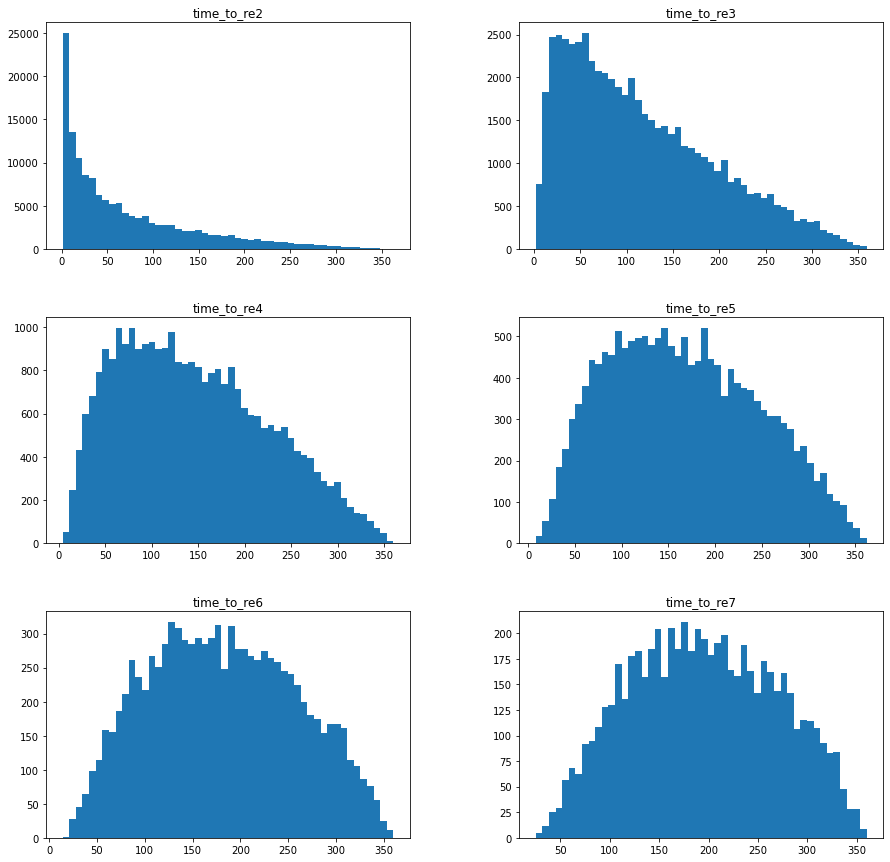

In [488]:
# Plotting time to each readmission

readmit_short_df[['time_to_re2','time_to_re3','time_to_re4',
                  'time_to_re5','time_to_re6','time_to_re7']].hist(bins=50,figsize=(15,15),grid=False)

In [489]:
readmit_short_df[['time_to_re2','time_to_re3','time_to_re4','time_to_re5','time_to_re6','time_to_re7']].describe()

,time_to_re2,time_to_re3,time_to_re4,time_to_re5,time_to_re6,time_to_re7
count,144388.000000,57772.000000,28660.000000,16210.000000,9792.000000,6344.000000
mean,71.009883,116.133854,145.683252,166.448304,181.782782,194.577869
std,72.619932,79.037594,79.223385,78.830106,76.791572,73.985274
min,1.000000,2.000000,4.000000,8.000000,14.000000,25.000000
25%,14.000000,50.000000,80.000000,103.000000,121.000000,136.000000
50%,45.000000,100.000000,137.000000,161.000000,179.000000,193.000000
75%,107.000000,169.000000,203.000000,226.000000,241.000000,253.000000
max,363.000000,359.000000,360.000000,362.000000,360.000000,360.000000


In [494]:
# Calculating readmission outcome variable (same versus different primary diagnosis within 90 days)

readmit_short_df['re_same_30'] = np.where((readmit_short_df['time_to_re2'] <= 30) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] == readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_diff_30'] = np.where((readmit_short_df['time_to_re2'] <= 30) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] != readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_same_60'] = np.where((readmit_short_df['time_to_re2'] <= 60) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] == readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_diff_60'] = np.where((readmit_short_df['time_to_re2'] <= 60) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] != readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_same_90'] = np.where((readmit_short_df['time_to_re2'] <= 90) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] == readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_diff_90'] = np.where((readmit_short_df['time_to_re2'] <= 90) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] != readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_same_120'] = np.where((readmit_short_df['time_to_re2'] <= 120) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] == readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)
readmit_short_df['re_diff_120'] = np.where((readmit_short_df['time_to_re2'] <= 120) & 
    (readmit_short_df['DXCCSR_DEFAULT_DX1'] != readmit_short_df['DXCCSR_DEFAULT_DX1_2']), 1, 0)

In [495]:
print("Number of readmissions within 30 days in first 11 months")
print(readmit_short_df[readmit_short_df.DMONTH <= 11]['re_same_30'].value_counts())
print(readmit_short_df[readmit_short_df.DMONTH <= 11]['re_diff_30'].value_counts())
print("\n")
print("Number of readmissions within 60 days in first 10 months")
print(readmit_short_df[readmit_short_df.DMONTH <= 10]['re_same_60'].value_counts())
print(readmit_short_df[readmit_short_df.DMONTH <= 10]['re_diff_60'].value_counts())
print("\n")
print("Number of readmissions within 90 days in first 9 months")
print(readmit_short_df[readmit_short_df.DMONTH <= 9]['re_same_90'].value_counts())
print(readmit_short_df[readmit_short_df.DMONTH <= 9]['re_diff_90'].value_counts())
print("\n")
print("Number of readmissions within 120 days in first 8 months")
print(readmit_short_df[readmit_short_df.DMONTH <= 8]['re_same_120'].value_counts())
print(readmit_short_df[readmit_short_df.DMONTH <= 8]['re_diff_120'].value_counts())
print("\n")

Number of readmissions within 30 days in first 11 months
0    705783
1     37257
Name: re_same_30, dtype: int64
0    722856
1     20184
Name: re_diff_30, dtype: int64


Number of readmissions within 60 days in first 10 months
0    637619
1     51480
Name: re_same_60, dtype: int64
0    661278
1     27821
Name: re_diff_60, dtype: int64


Number of readmissions within 90 days in first 9 months
0    570071
1     58562
Name: re_same_90, dtype: int64
0    596773
1     31860
Name: re_diff_90, dtype: int64


Number of readmissions within 120 days in first 8 months
0    510192
1     62210
Name: re_same_120, dtype: int64
0    538488
1     33914
Name: re_diff_120, dtype: int64




In this analysis, we have restricted our sample to patients who have been admitted with an MBD (Mental, Behavioral, and Neurodevelopmental Disorder) diagnosis associated with their primary reason for hospitalization, yielding a sample of 795,055 unique admission records; this removed 4,613,231 unique admission records for which an MBD diagnosis is a comborbidity. In a future analysis, we could include these records and code an indicator of whether their MBD diagnosis is primary or secondary.

In coding these records for readmission, the standards yielding the best balance of total records and readmission records were any readmission within 90 days of discharge occuring within the first 9 months of the year. 58,562 patients (9.32%) were readmitted for the same primary diagnosis, 31,860 patients (5.07%) were readmitted for a different primary diagnosis, and 538,211 patients (85.62%) were never readmitted under these criteria.

In [511]:
# Preparing the final dataset for modeling

modeling_df = readmit_short_df.drop(columns=['Visit_Count','NRD_VisitLink','NRD_DaysToEvent','DISCWT',
                                             'NRD_STRATUM','HOSP_NRD','KEY_NRD',
                                             'NRD_DaysToEvent_2','DXCCSR_DEFAULT_DX1_2','Primary_dx_2',
                                             'NRD_DaysToEvent_3','DXCCSR_DEFAULT_DX1_3','Primary_dx_3',
                                             'NRD_DaysToEvent_4','DXCCSR_DEFAULT_DX1_4','Primary_dx_4',
                                             'NRD_DaysToEvent_5','DXCCSR_DEFAULT_DX1_5','Primary_dx_5',
                                             'NRD_DaysToEvent_6','DXCCSR_DEFAULT_DX1_6','Primary_dx_6',
                                             'NRD_DaysToEvent_7','DXCCSR_DEFAULT_DX1_7','Primary_dx_7',
                                             'time_to_re3','time_to_re4','time_to_re5','time_to_re6','time_to_re7',
                                             're_same_30','re_diff_30','re_same_60','re_diff_60','re_same_120',
                                             're_diff_120','re_same_180','re_diff_180','time_to_re2'])
modeling_df['re_any_90'] = modeling_df.re_same_90 + modeling_df.re_diff_90
modeling_df['SAMEDAYEVENT'] = np.where(modeling_df['SAMEDAYEVENT'].astype('int64') >= 1, 1, 0)
modeling_df['HCUP_ED'] = np.where(modeling_df['HCUP_ED'].astype('int64') >= 1, 1, 0)

In [515]:
modeling_df.to_csv(r'D:\MLE Capstone Project\Data\modeling_data.csv', index=False)